<a href="https://colab.research.google.com/github/ML-Bioinfo-CEITEC/ECCB2021/blob/main/notebooks/06_Regularization_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up

In [1]:
from tensorflow import keras as K
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Regularization

Regularizations are techniques used to reduce the error by fitting a function appropriately on the given training set and avoid overfitting. 

## Overfitting explained

Overfitting is a concept in data science, which occurs when a statistical model fits exactly against its training data. When this happens, the algorithm unfortunately cannot perform accurately against unseen data, defeating its purpose. Generalization of a model to new data is ultimately what allows us to use machine learning algorithms to make predictions and classify data.

In simple words, overfitting means that the model achieves very high accuracy on the initial training data and very low accuracy on newly unseen data. It is like when teachers always give the same questions in their exams. Their students would easily get very high grades, because they simply memorized the answers. Therefore, the high grades are not a good metric here.

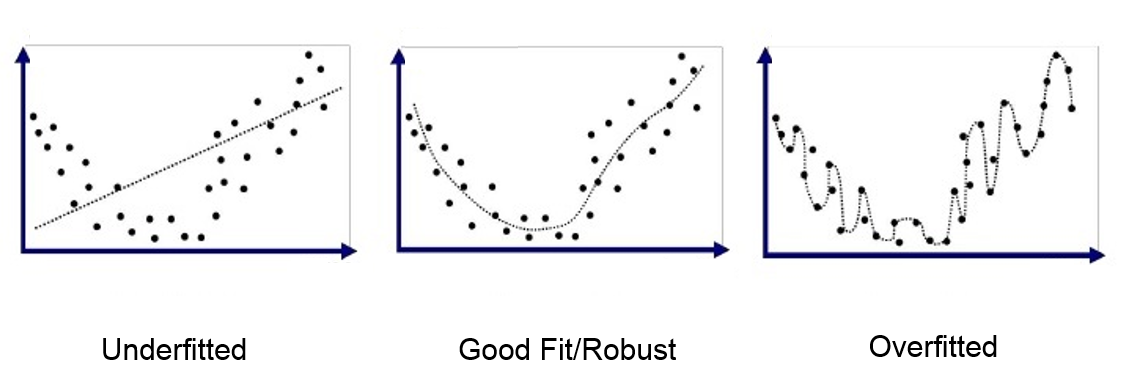

There are various regularization methods. We will have a look at dropout, batch normalization, and weight decay. Other approaches to deal with overfitting are data augmentation, more training samples (larger dataset), tuning the number of parameters of your model (the amount of neurons and layers), early stopping ...

## Dropout explained

We chose to forbid some neurons of answering and give chance to others. This way we will achieve balance and force all neurons to learn. The key idea is to randomly drop units (along with their connections) from the neural network during training. This prevents units from co-adapting too much. 

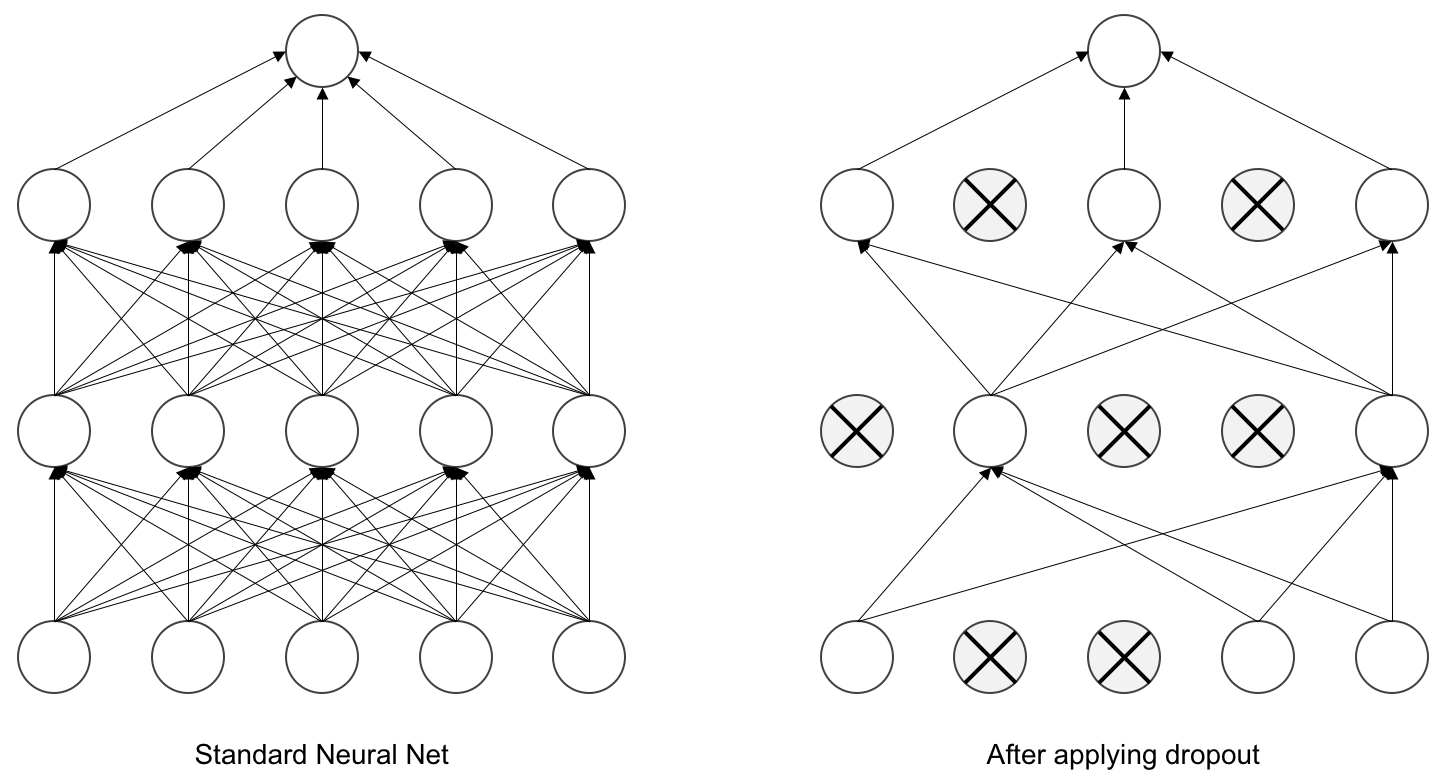



1.   We assign a dropout rate, which represents the percentage of neurons to drop (e.g. 20% of neurons).
2.   At each stage, we remove random neurons according to the predefined percentage.
3.   We calculate the final output according to the combination of results from the remaining neurons.







## Load and preprocess datasets

In [2]:
# get train dataset
!wget --quiet https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/penguinn/master/Datasets/train_set_1_1.txt

nucleo_dic = {
    "A": 0,
    "C": 1,
    "T": 2,
    "G": 3,
    "N": 4,
}

df_train = pd.read_csv("train_set_1_1.txt", sep='\t', names=['sequence', 'label'])

# translate text labels to numbers 0, 1
labels_train = np.array(list(map((lambda x: 1 if x == 'positive' else 0), list(df_train['label']))))
dataset_train = df_train['sequence'].tolist()
# numericalize using the dictionary
dataset_ordinal_train = [[nucleo_dic[letter] for letter in sequence] for sequence in dataset_train]
# translate number values to one-hot vectors
dataset_onehot_train = tf.one_hot(dataset_ordinal_train, depth=5)


In [3]:
# get test dataset
!wget --quiet https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/penguinn/master/Datasets/test_set_1_1.txt

# preprocess the test set similarly
df_test = pd.read_csv("test_set_1_1.txt", sep='\t', names=['sequence', 'label'])

labels_test = np.array(list(map((lambda x: 1 if x == 'positive' else 0), list(df_test['label']))))
dataset_test = df_test['sequence'].tolist()

# we use the same nucleo_dic as on the example before
dataset_ordinal_test = [[nucleo_dic[letter] for letter in sequence] for sequence in dataset_test]
dataset_onehot_test = tf.one_hot(dataset_ordinal_test, depth=5)

In [4]:
# Make the training dataset smaller to demonstrate overfitting.
number_of_examples = 300

print(dataset_onehot_train[0:number_of_examples].shape)
print(labels_train[0:number_of_examples].shape)

dataset_onehot_train_small = dataset_onehot_train[0:number_of_examples]
labels_train_small = labels_train[0:number_of_examples]

(300, 200, 5)
(300,)


In [5]:
# sequence_size = length of the sequence
sequence_size = 200
# channel = each channel corresponds to a nucleotide
channel = len(nucleo_dic)

## Old Model

In [6]:
# create the NN model
old_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(
    filters=10,
    kernel_size=6,
    strides=1,
    padding='same',
    data_format="channels_last",
    activation='relu',
    input_shape=(sequence_size, channel)),

  tf.keras.layers.Conv1D(
    filters=10,
    kernel_size=6,
    strides=1,
    padding='same',
    data_format="channels_last",
    activation='relu'),
  
  tf.keras.layers.Flatten(),
  
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = K.optimizers.SGD()

old_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [7]:
validation_split=0.5
num_epochs=50

old_history = old_model.fit(
    dataset_onehot_train_small,
    labels_train_small,
    batch_size=32,
    epochs=num_epochs,
    # notice the validation split, this split is always taken from the end of the training dataset before shuffle
    #   so, as long as our dataset is the same, train-validation split will also be the same
    validation_split=validation_split
)

Epoch 1/50
5/5 [==============================] - 2s 100ms/step - loss: 0.6861 - accuracy: 0.5667 - val_loss: 0.6912 - val_accuracy: 0.5333
Epoch 2/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6790 - accuracy: 0.5600 - val_loss: 0.6896 - val_accuracy: 0.5333
Epoch 3/50
5/5 [==============================] - 0s 14ms/step - loss: 0.6747 - accuracy: 0.5733 - val_loss: 0.6873 - val_accuracy: 0.5333
Epoch 4/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6706 - accuracy: 0.5667 - val_loss: 0.6853 - val_accuracy: 0.5333
Epoch 5/50
5/5 [==============================] - 0s 13ms/step - loss: 0.6664 - accuracy: 0.5867 - val_loss: 0.6831 - val_accuracy: 0.5333
Epoch 6/50
5/5 [==============================] - 0s 13ms/step - loss: 0.6617 - accuracy: 0.5800 - val_loss: 0.6812 - val_accuracy: 0.5400
Epoch 7/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6590 - accuracy: 0.5800 - val_loss: 0.6785 - val_accuracy: 0.5333
Epoch 8/50
5/5 [==========

## Model with dropout

In [8]:
# create the NN model

dropout_rate = 0.2

model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(
    filters=10,
    kernel_size=6,
    strides=1,
    padding='same',
    data_format="channels_last",
    activation='relu',
    input_shape=(sequence_size, channel)),

# The Dropout layer randomly sets input units to 0 with a frequency of rate
#  at each step during training time, which helps prevent overfitting. 
# Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged
  tf.keras.layers.Dropout(dropout_rate),

  tf.keras.layers.Conv1D(
    filters=10,
    kernel_size=6,
    strides=1,
    padding='same',
    data_format="channels_last",
    activation='relu'),

  tf.keras.layers.Dropout(dropout_rate),
  
  tf.keras.layers.Flatten(),
  
  tf.keras.layers.Dense(10, activation="relu"),
  
  tf.keras.layers.Dropout(dropout_rate),

  tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = K.optimizers.SGD()

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)




In [9]:
old_model.summary()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 200, 10)           310       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 10)           610       
_________________________________________________________________
flatten (Flatten)            (None, 2000)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20010     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 20,941
Trainable params: 20,941
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 O

In [10]:
history = model.fit(
    dataset_onehot_train_small,
    labels_train_small,
    batch_size=32,
    epochs=num_epochs,
    # notice the validation split, this split is always taken from the end of the training dataset before shuffle
    #   so, as long as our dataset is the same, train-validation split will also be the same
    validation_split=validation_split
)

Epoch 1/50
5/5 [==============================] - 1s 57ms/step - loss: 0.6895 - accuracy: 0.5533 - val_loss: 0.6898 - val_accuracy: 0.4867
Epoch 2/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6953 - accuracy: 0.5733 - val_loss: 0.6886 - val_accuracy: 0.5000
Epoch 3/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6896 - accuracy: 0.5000 - val_loss: 0.6877 - val_accuracy: 0.5000
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 0.6835 - accuracy: 0.5267 - val_loss: 0.6863 - val_accuracy: 0.5133
Epoch 5/50
5/5 [==============================] - 0s 13ms/step - loss: 0.6981 - accuracy: 0.5000 - val_loss: 0.6853 - val_accuracy: 0.5133
Epoch 6/50
5/5 [==============================] - 0s 14ms/step - loss: 0.6818 - accuracy: 0.5467 - val_loss: 0.6844 - val_accuracy: 0.5333
Epoch 7/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6695 - accuracy: 0.6067 - val_loss: 0.6835 - val_accuracy: 0.5400
Epoch 8/50
5/5 [===========

## Plot learning curves

In [11]:
# evaluate on the testing dataset
# old model
old_metrics = old_model.evaluate(
    dataset_onehot_test,
    labels_test,
    verbose=0
)
# new model with dropout
metrics = model.evaluate(
    dataset_onehot_test,
    labels_test,
    verbose=0
)


In [15]:
# Simple trick for the visualization

print('simple model evaluation on unknown (that is "test") dataset [loss, accuracy]:', old_metrics)
print('dropout model evaluation on unknown (that is "test") dataset [loss, accuracy]:', metrics)
for met in range(len(old_metrics)):
  repeted_list = []
  for i in range(len(history.history['accuracy'])):
    repeted_list.append(old_metrics[met])
  old_metrics[met] = repeted_list
# print(old_metrics)

for met in range(len(metrics)):
  repeted_list = []
  for i in range(len(history.history['accuracy'])):
    repeted_list.append(metrics[met])
  metrics[met] = repeted_list
# print(metrics)


simple model evaluation on unknown (that is "test") dataset [loss, accuracy]: [[0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.44893553853034973, 0.448935538530349

For the dropout model the training metrics are closer to the evaluation metric


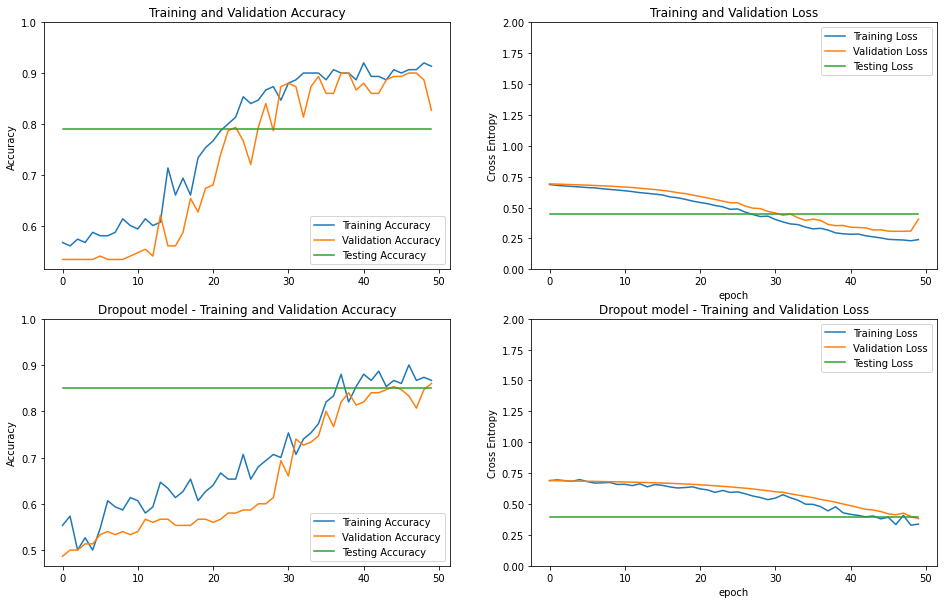

In [14]:
print("For the dropout model the training metrics are closer to the evaluation metric")
# print training history
old_acc = old_history.history['accuracy']
old_val_acc = old_history.history['val_accuracy']

old_loss = old_history.history['loss']
old_val_loss = old_history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# acc
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(old_acc, label='Training Accuracy')
plt.plot(old_val_acc, label='Validation Accuracy')
plt.plot(old_metrics[1], label='Testing Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# loss
plt.subplot(2, 2, 2)
plt.plot(old_loss, label='Training Loss')
plt.plot(old_val_loss, label='Validation Loss')
plt.plot(old_metrics[0], label='Testing Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

# acc
plt.subplot(2, 2, 3)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot(metrics[1], label='Testing Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Dropout model - Training and Validation Accuracy')

# loss
plt.subplot(2, 2, 4)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot(metrics[0], label='Testing Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Dropout model - Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

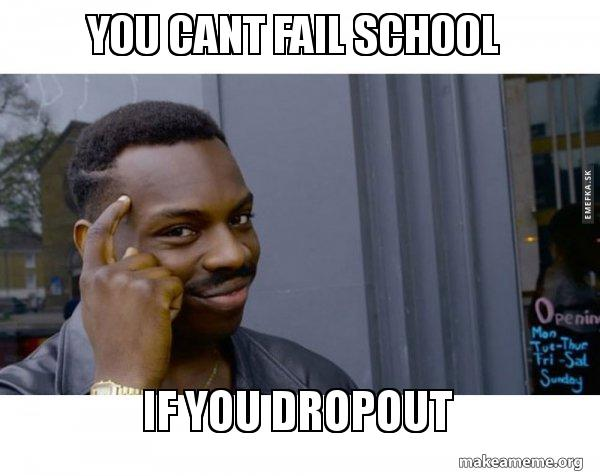